In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from art_laser_attack import LaserBeamAttack, LaserBeam, LaserBeamGenerator, ImageGenerator
from art.attacks.evasion.laser_attack.utils import add_images
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from art.attacks.evasion.laser_attack.utils import wavelength_to_rgb
from sklearn.model_selection import train_test_split
import keras
from keras.models import load_model

c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#GHTSRB dataset

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

#finding total classes
NUM_CATEGORIES = 43


classes={0:'Speed limit(20km/hr)',
         1:'Speed limit(30km/hr)',
         2:'Speed limit(50km/hr)',
         3:'Speed limit(60km/hr)',
         4:'Speed limit(70km/hr)',
         5:'Speed limit(80km/hr)',
         6:'End of speed limt(80km/hr)',
         7:'Speed limit(100km/hr)',
         8:'Speed limit(120km/hr)',
         9:'No passing',
         10:'No passing vehicles over 3.5 tons',
         11:'Right- of- way at inetersection',
         12:'Priority road',
         13:'Yield',
         14:'Stop',
         15:'No vehicles',
         16:'Vehicles greater than 3.5 tons prohibited',
         17:'No entry',
         18:'General Caution',
         19:'Dangers curve left',
         20:'Dangers curve Right',
         21:'Double curve',
         22:'Bumpy road',
         23:'Slippery road',
         24:'Road narrows on the right',
         25:'Road work',
         26:'Traffic signals',
         27:'Pedestrians',
         28:'Children crossing ',
         29:'Bicycle crossing',
         30:'Beware of ice/snow',
         31:'Wild animal crossing',
         32:'End speed + passing limits',
         33:'Turn right ahead',
         34:' Turn left ahead',
         35:'Ahead only',
         36:'Go straight or right',
         37:'Go straight or left',
         38:'Keep right',
         39:'Kepp left',
         40:'Rounabout mandatory',
         41:'End of no passing',
         42:'End of no passingVehicle greater than 3.5tons'
        }



In [4]:
#Making model
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [3]:
# Load model
model = load_model('model.h5')

In [4]:
# Target image

path ="./stop.png"

image = cv2.imread(path)
image_fromarray = Image.fromarray(image)
resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
img= np.array(resize_image)/255

img_label = np.zeros((43,1))
img_label[14]=1

REAL_CLASS = np.argmax(img_label)

input_shape = img.shape
img=np.array(img,dtype=np.float32)

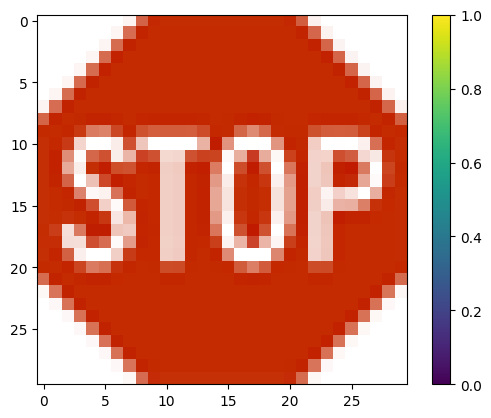

good prediction initially: tf.Tensor(True, shape=(), dtype=bool)
real class : Stop
initial class predicted: Stop


In [5]:
# Display the initial image
c=plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.colorbar(c)
plt.show()

# Save the initial image
cv2.imwrite('./Results/initial_image.png', img*255)

# Predictions for the initial image
def predict_image_class(image, model):
    image_expanded = tf.expand_dims(image, 0)
    predicted = tf.argmax(model(image_expanded), 1)
    return predicted

prediction = predict_image_class(img, model)[0]
print("good prediction initially:",(prediction == REAL_CLASS))
print("real class :",classes[REAL_CLASS])
print("initial class predicted:",classes[int(prediction)])


In [10]:
tf.keras.backend.set_image_data_format('channels_last')
channels_first=False

# Attack
max_width = 30
min_width = 0
max_wavelength = 380
min_wavelength = 780

attack = LaserBeamAttack(
    estimator=model,
    channels_first=channels_first, 
    iterations=500,
    min_laser_beam=(min_wavelength, 0.0, 0, min_width),    # parameters : (wavelength, angle (radians), bias, width)
    max_laser_beam=(max_wavelength, 3.14, 30, max_width))

In [11]:
# Generate laser parameters instead of images

adversarial_laser, adversarial_class = attack.generate_parameters(x=tf.expand_dims(img, axis=0))[0]

adversarial_laser_image = ImageGenerator().generate_image(adversarial_laser, shape=input_shape)

adversarial_image = add_images(img, adversarial_laser_image)

1/1 [==============================] - 0s 30ms/step


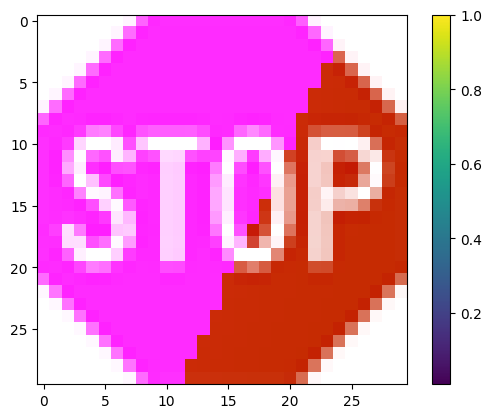

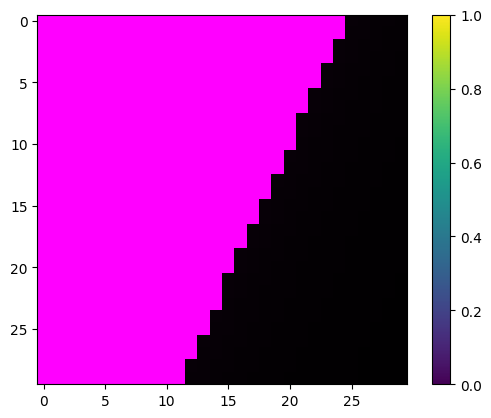

In [12]:
# Display the adversarial image
adversarial_image = np.array(adversarial_image,dtype=np.float32)
c = plt.imshow(cv2.cvtColor(adversarial_image, cv2.COLOR_BGR2RGB))
plt.colorbar(c)
plt.show()


# Display the laser beam
adversarial_laser_image = np.array(adversarial_laser_image,dtype=np.float32)
c = plt.imshow(cv2.cvtColor(adversarial_laser_image, cv2.COLOR_BGR2RGB))
plt.colorbar(c)
plt.show()

In [13]:
# Prediction
adv_pred = predict_image_class(adversarial_image, model)
print("class predicted after the attack:",classes[int(adv_pred)])

prediction_value = float(model(tf.expand_dims(adversarial_image,0))[0,int(REAL_CLASS)])
print("Prediction value:",prediction_value)

if adv_pred != prediction:
    print("Attack sucessful")
else:
    print("Attack failed")

class predicted after the attack: Speed limit(30km/hr)
Prediction value: 0.14313466846942902
Attack sucessful


In [14]:
# Save the adversarial image and the laser beam
adv_image = np.array(adversarial_image)
cv2.imwrite('./Results/adv_laser.png', adversarial_laser_image*255)
cv2.imwrite('./Results/adv_image_recomposed.png', adv_image*255)

True

In [15]:
# Results
print("BGR wavelength:",adversarial_laser.wavelength)
print("Angle of the line in radian:",adversarial_laser.line.angle)
print("Bias of the angle:",adversarial_laser.line.bias)
print("Width:",adversarial_laser.width)

[r,g,b] = wavelength_to_rgb(adversarial_laser.wavelength)
print("RGB color:","R:",b*255,"G:",g*255,"B:",r*255)

BGR wavelength: 380.0
Angle of the line in radian: 2.708075294473657
Bias of the angle: 10.409712037925786
Width: 25.87333083892029
RGB color: R: 255.0 G: 0.0 B: 255.0
